### Thermodynamics
#### Unifac method - Activity coefficients

In [98]:
import numpy as np
import pandas as pd
import CoolProp.CoolProp as CP
import scipy.optimize as opt
import matplotlib.pyplot as plt
%matplotlib inline

Molecular group data, extracted from material.

In [66]:
groups = { # main: {secondary i:[molecule,R,Q],secondary i+1:[molécula,R,Q],etc}
    1: {1:['CH3',0.9011,0.848],2:['CH2',0.6744,0.540],3:['CH',0.4469,0.228],4:['C',0.2195,0]},
    2: {5:['CH2CH',1.3454,1.176],6:['CHCH',1.1167,0.867],7:['CH2C',1.1173,0.988],8:['CHC',0.8886,0.676],70:['CC',0.6605,0.485]},
    3: {9:['ACH',0.5313,0.400],10:['AC',0.3652,0.120]},
    4: {11:['ACCH3',1.2663,0.968],12:['ACCH2',1.0396,0.660],13:['ACCH',0.8121,0.348]},
    5: {14:['OH',1.000,1.200]},
    6: {15:['CH3OH',1.4311,1.432]},
    7: {16:['H2O',0.9200,1.400]},
    8: {17:['ACOH',0.8952,0.680]},
    9: {18:['CH3CO',1.6724,1.488],19:['CH2CO',1.4457,1.180]},
    10: {20:['CHO',0.9980,0.948]},
    11: {21:['CH3COO',1.9031,1.728],22:['CH2COO',1.6764,1.420]},
    12: {23:['HCOO',1.2420,1.188]}
}
g_groups = {}
for i in groups.values():
    g_groups.update(i)
    
a_mn = pd.read_csv('a-mn.csv', sep=';', index_col=0)
a_mn.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
1,0.00,8602.000,61.13,76.50,986.5,697.2,1318.0,1333.0,476.40,677.0,232.100,507.0,251.50,391.500,255.70,206.60,920.70,287.800
2,-35.36,0.000,38.81,74.15,524.1,787.6,270.6,526.1,182.60,448.8,37.850,333.5,214.50,240.900,163.90,61.11,749.30,2811.500
3,-11.12,3.446,0.00,167.00,636.1,637.4,903.8,1329.0,25.77,347.3,5.994,287.1,32.14,161.700,122.80,9049.00,648.20,-4.449
4,-69.70,-113.600,-146.80,0.00,803.2,603.3,5695.0,4.9,-52.10,586.8,5688.000,197.8,213.10,19.020,-49.29,23.50,663.20,52.800
5,156.40,457.000,89.60,25.82,0.0,-137.1,353.5,-259.7,84.00,-203.6,101.100,267.8,28.06,8.642,42.70,-3210.00,-52.39,170.000


**Molecule class and it's methods:**
* initializer - molecular group code and its respective amount
* **combinatiorial activity coefficient**
    * r, q and l coefficients
    * $\phi$ and $\theta$ factors
    * $\gamma^c$ - combinatorial activity coefficient
* **residual activity coefficient** - _the hard one_
    * $\psi$ factor
    * $\Gamma_k$
        * X and $\theta$
    * $\Gamma_k^i$
        * $X^i$ and $\theta^i$
    * $\ln{\gamma^r} = \sum \nu_k (\ln\Gamma_k - \ln\Gamma_k^i)$
* **acitivity coefficient**
    * $\ln{\gamma} = \ln{\gamma^c} + \ln{\gamma^r}$

In [64]:
class molecule():
    def __init__(self,molGroups):
        self.g = molGroups.keys()
        self.v = molGroups.values()
        self.groups = molGroups        
        
    def rql(self):
        z,r,q = 10,0,0        
        num = len(self.g)
        if num > 1:
            for i,k in zip(self.g,self.v):
                r += g_groups[i][1] * k
                q += g_groups[i][2] * k
        else:
            r = g_groups[tuple(self.g)[0]][1] * tuple(self.v)[0]
            q = g_groups[tuple(self.g)[0]][2] * tuple(self.v)[0]
        self.l = 0.5 * z * (r - q) - (r - 1)
        self.r,self.q = r,q
        return(self.r,self.q,self.l)
    
    def phi_theta(self, fluid):
        phi,theta = {},{}       
        phi[self] = self.r * x / (self.r * x + fluid.r * (1 - x))
        phi[fluid] = fluid.r * (1 - x) / (self.r * x + fluid.r * (1 - x))
        theta[self] = self.q * x / (self.q * x + fluid.q * (1 - x))
        theta[fluid] = fluid.q * (1 - x) / (self.q * x + fluid.q * (1 - x))
        self.phi, self.theta = phi[self], theta[self]
        fluid.phi, fluid.theta = phi[fluid], theta[fluid]
        return(self.phi, self.theta, fluid.phi, fluid.theta)
    
    def combinatorial(self, fluid):
        self.x, fluid.x = x, (1-x)
        self.gamma_c_ln = np.log(self.phi / self.x) + 5 * self.q * np.log(self.theta / self.phi) + \
                    self.l - (self.phi / self.x) * ( fluid.x * fluid.l + self.x * self.l )
        fluid.gamma_c_ln = np.log(fluid.phi / fluid.x) + 5 * fluid.q * np.log(fluid.theta / fluid.phi) + \
                    fluid.l - (fluid.phi / fluid.x) * ( self.x * self.l + fluid.x * fluid.l )
        self.gamma = np.exp(self.gamma_c_ln)
        fluid.gamma = np.exp(fluid.gamma_c_ln)
        return(self.gamma_c_ln, fluid.gamma_c_ln)    
        
    def psi_mod(self, fluid, pairs):
        self.p = tuple([(i,j) for i in pairs for j in pairs])
        a, psi = {}, {}
        for i in self.p:
            j = (i[0]-1,i[1]-1)
            a[i] = a_mn.iat[j]
            psi[i] = np.exp(-a_mn.iat[j] / T)
        self.a_k, self.a_v, self.a = a.keys(), a.values(), a
        self.psi_k, self.psi_v, self.psi = psi.keys(), psi.values(), psi
        self.psi_matrix = np.reshape(np.array([self.psi[i] for i in self.p]),(len(pairs),len(pairs)))
        return(self.a_k, self.a_v, self.a)
        return(self.psi_k, self.psi_v, self.psi)
        return(self.p)
        return(self.psi_matrix)
    
    def X_mod(self, fluid):                
        den = sum([self.groups[k] for k in list(self.g)]) * self.x + \
              sum([fluid.groups[k] for k in list(fluid.g)]) * fluid.x
        X = []
        v1, v2 = list(self.v), list(fluid.v)
        Xi = np.array(v1) / sum(v1), np.array(v2) / sum(v2)
        self.Xi = Xi
        g_list = list(set([i for j in [list(self.g),list(fluid.g)] for i in j]))
        for k in sorted(g_list):
            nom = 0
            if k in list(self.g):
                nom += self.groups[k] * self.x
            if k in list(fluid.g):
                nom += fluid.groups[k] * fluid.x
            X.append(nom / den)      
        self.X = X       
        return(self.X)
        return(self.Xi)
    
    def Theta_mod(self, fluid):
        g_list = list(set([i for j in [list(self.g),list(fluid.g)] for i in j]))
        nom = np.multiply(np.transpose(self.X) ,np.array([g_groups[k][2] for k in sorted(g_list)]))
        den = sum(nom)
        self.Theta = np.divide(nom, den)
        return(self.Theta)
    
    def Theta_mod_i(self, fluid):
        g1, g2 = list(self.g), list(fluid.g)
        Q1, Q2 = [g_groups[i][2] for i in g1], [g_groups[i][2] for i in g2]
        nom1, nom2 = np.multiply(self.Xi[0],Q1), np.multiply(self.Xi[1],Q2)
        den1, den2 = sum(nom1), sum(nom2)
        self.Theta1, self.Theta2 = nom1 / den1, nom2 / den2
        return(self.Theta1, self.Theta2)
    
    def Gamma_k(self, fluid):
        g_list = list(set([i for j in [list(self.g),list(fluid.g)] for i in j]))
        Q = [g_groups[k][2] for k in sorted(g_list)]
        nTheta = np.reshape(self.Theta,(len(self.psi_matrix),1))
        pt = np.multiply(self.psi_matrix,nTheta)
        pt2 = np.multiply(self.psi_matrix,self.Theta)
        denom = np.sum(pt,axis=0)
        gam = 1 - np.log(denom) - np.sum(np.divide([i for i in pt2],denom),axis=1)
        self.gamma_k_ln = np.multiply(Q,gam)
        return(self.gamma_k_ln)
    
    def Gamma_k_i(self, fluid):
        t1, t2 = self.Theta1, self.Theta2
        g1, g2 = list(self.g), list(fluid.g)
        Q1, Q2 = [g_groups[i][2] for i in g1], [g_groups[i][2] for i in g2]
        Y = self.psi_matrix
        a, b = np.multiply([Y[0,0],Y[2,0]], t1), np.multiply([Y[0,2],Y[2,2]], t1)
        c, d = np.multiply([Y[0,0],Y[1,0]], t2), np.multiply([Y[0,1],Y[1,1]], t2)
        e, f = np.multiply([Y[0,0],Y[0,2]], t1), np.multiply([Y[2,0],Y[2,2]], t1)
        g, h = np.multiply([Y[0,0],Y[0,1]], t1), np.multiply([Y[1,0],Y[1,1]], t2)
        gamma_1 = Q1[0] * (1 - np.log(sum(a)) - e[0] / sum(a) - e[1] / sum(b) )
        gamma_2 = Q1[1] * (1 - np.log(sum(b)) - f[0] / sum(a) - f[1] / sum(b) )
        gamma_3 = Q2[0] * (1 - np.log(sum(c)) - g[0] / sum(c) - g[1] / sum(d) )
        gamma_4 = Q2[1] * (1 - np.log(sum(d)) - h[0] / sum(c) - h[1] / sum(d) )        
        return(gamma_1,gamma_2,gamma_3,gamma_4)
    
    def residual(self, fluid):
        v1, v2 = list(self.v), list(fluid.v)
        k_i = self.Gamma_k_i(fluid)
        g1 = np.array([self.Gamma_k(fluid)[0],self.Gamma_k(fluid)[1]])
        g2 = np.array([self.Gamma_k(fluid)[0],self.Gamma_k(fluid)[2]])
        gamma_r_ln_1 = sum(np.multiply(v1,g1-k_i[:2]))
        gamma_r_ln_2 = sum(np.multiply(v2,g2-k_i[2:]))
        gamma_r_1, gamma_r_2 = np.exp(gamma_r_ln_1), np.exp(gamma_r_ln_2)
        return(gamma_r_ln_1, gamma_r_ln_2)
    
    def Gamma(self, fluid):
        yr = self.residual(fluid)
        print(yr,'\n')
        yc = self.combinatorial(fluid)
        print(yc,'\n')
        y_ln = np.add(yr, yc)
        print(y_ln)
        self.y = np.exp(y_ln)
        return(self.y)

In [85]:
#x = np.linspace(0.047,0.9,9) 
x = 0.2
T = 298.15
propane = molecule({1:2,2:1})
isobutane = molecule({1:2,3:1})
print(propane.rql(),isobutane.rql())
propane.phi_theta(isobutane)
print(propane.phi)
print(propane.theta)
print(propane.combinatorial(isobutane))
print(x)
print(isobutane.phi)
print(isobutane.theta)
print((1-x))
print(propane.combinatorial(isobutane),'\n')
print(propane.gamma)
print(isobutane.gamma)
propane.psi_mod(isobutane,[1,1,1])
print(propane.psi_matrix)
#print([(methanol.psi[i],i) for i in methanol.p])
propane.X_mod(isobutane)
print(propane.Theta_mod(isobutane))
propane.Gamma_k(isobutane)
propane.Theta_mod_i(isobutane)
propane.Gamma_k_i(isobutane)
print(propane.residual(isobutane),'\n')
print('--','\n')
propane.Gamma(isobutane)
propane.y

(2.4766, 2.2359999999999998, -0.2735999999999992) (2.2491, 1.924, 0.37639999999999985)
0.2158633312995729
0.225130890052356
(0.0067523898104470126, 0.0004833751050150048)
0.2
0.7841366687004271
0.774869109947644
0.8
(0.0067523898104470126, 0.0004833751050150048) 

1.00677523859
1.00048349195
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
[ 0.85380588  0.05436971  0.09182441]
(2.4824586830618498e-16, 2.0411450307733503e-16) 

-- 

(2.4824586830618498e-16, 2.0411450307733503e-16) 

(0.0067523898104470126, 0.0004833751050150048) 

[ 0.00675239  0.00048338]


array([ 1.00677524,  1.00048349])

In [86]:
p_sat_but = CP.PropsSI('P','T',T,'Q',0,'Isobutane') / 1000
p_sat_prop = CP.PropsSI('P','T',T,'Q',0,'Propane') / 1000
print(p_sat_but, p_sat_prop)

350.66962756803474 952.0745233424223


In [89]:
Var = CP.AbstractState('HEOS', 'Propane&Isobutane')
Var.set_mole_fractions([x,1-x])
Var.update(CP.QT_INPUTS, 0, T)
B = Var.Bvirial()
R = 8.314
phi_but = B * p_sat_but / (R * T)
phi_prop = B * p_sat_prop / (R * T)

[0.0, 0.25457220566140787, 0.4383908725963433, 0.5773539880725298, 0.68609468081701608, 0.77350536192607178, 0.84530145455595429, 0.90532386226213035, 0.95624922805221468, 0.0] [350.83917350992857, 418.35982705292474, 485.8804805959208, 553.40113413891686, 620.92178768191309, 688.44244122490909, 755.96309476790532, 823.48374831090132, 891.00440185389755, 0.0]


C:\Users\Júlio\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


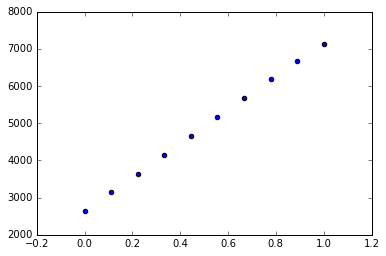

In [109]:
def sistema(v):
    y, p = v[0], v[1]
    return(y * p * phi_prop - f_l_prop, \
           (1-y) * p * phi_but - f_l_but)
guess = (0, 0)
y1,p1 = [], []
for x in np.linspace(0,1,10):
    f_l_prop = x * propane.y[0] * phi_prop * p_sat_prop
    f_l_but = (1-x) * propane.y[1] * phi_but * p_sat_but
    y, p =  opt.fsolve(sistema, guess)
    y1.append(y)
    p1.append(p)
print(y1,p1)
p1[0], p1[-1] = p_sat_but, p_sat_prop
p1 = np.array(p1)*760/101.325
plt.scatter(np.linspace(0,1,10),p1)

In [7]:
T = 307
pentano = molecule({1:2,2:3})
acetona = molecule({1:1,18:1})
print(pentano.rql(),acetona.rql())

(3.8254, 3.316, -0.27839999999999865) (2.5735, 2.336, -0.3859999999999988)


#### pentane-ketone mixture - combinatorial
* r,q and l coefficients
* $\phi$ and $\theta$ factors
* $\gamma^c$ coefficient

In [8]:
acetona.rql()
acetona.phi_theta(pentano)
acetona.combinatorial(pentano)
print(acetona.phi,acetona.theta,pentano.phi,pentano.theta)
print(acetona.gamma,acetona.gamma_c_ln,pentano.gamma,pentano.gamma_c_ln)

0.032112717578134345 0.03357615124436534 0.9678872824218657 0.9664238487556346
0.948648194133 -0.0527172612915 0.999898235766 -0.000101769412499


#### residual
the $\gamma^r$ coefficient requires a few factors in order to be computed:
* psi

In [9]:
acetona.psi_mod(pentano,[1,1,9])
acetona.psi_matrix

array([[ 1.        ,  1.        ,  0.21186807],
       [ 1.        ,  1.        ,  0.21186807],
       [ 0.91652483,  0.91652483,  1.        ]])

In [ ]:
acetona.X_mod(pentano)
print(acetona.X)
print(acetona.Xi[1])

In [ ]:
print(acetona.Theta_mod(pentano))

In [ ]:
acetona.Gamma_k(pentano)

In [ ]:
acetona.Theta_mod_i(pentano)[0]

In [ ]:
acetona.Gamma_k_i(pentano)

In [ ]:
acetona.residual(pentano)

In [ ]:
acetona.Gamma(pentano)